In [1]:
#Created by John Pesarchick
#Due 4/14/2023

import pandas as pd
import scipy
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import neurokit2 as nk
import pyxdf
import scipy as sp
import scipy.signal
import sklearn
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

#The objective of this notebook is to deploy SVMs on EMG and IMU data derived from a Myo Armband. The two types of data 
#are segregated to see which motions are best classified with each. In our project, IMU and EMG data may be handled separately
#and fused together after initial ML is performed on each type. For comparison, a final run is completed using both the EMG and 
#IMU data simultaneously. It appears EMG data is better suited for classifying the smaller movements like wrist rotations, and 
#IMU is better for larger motions such as the movement of one's entire arm. Using both types concurrently with a linear kernel
#yields the highest classification accuracy of ~81%. 

In [2]:
#Function to apply bandpass and bandstop filtering 
def filteremg(emg, notch, sfreq, high_band, low_band):
    """
    emg: EMG data
    high: high-pass cut off frequency
    low: low-pass cut off frequency
    sfreq: sampling frequency
    """
    # Zero mean emg signal
    emg = emg - emg.mean()
    
    # normalise cut-off frequencies to sampling frequency
    high_band = high_band/(sfreq/2)
    low_band = low_band/(sfreq/2)
    
    
    # create bandpass filter for EMG
    b1, a1 = sp.signal.butter(4, [high_band,low_band], btype='bandpass', analog=True)
    
    # process EMG signal: filter EMG
    emg_filtered = sp.signal.filtfilt(b1, a1, emg)    
    
    # process EMG signal: rectify
    emg_rectified = abs(emg_filtered)
    
    # create notch filter and apply to rectified signal to get EMG envelope
    #the cutoff for the filter is defined by the following two lines...
    high_band = (notch - 3)/(sfreq/2)
    low_band = (notch + 3)/(sfreq/2)
    #...and the filter is creted here. 
    b2, a2 = sp.signal.butter(4, [high_band,low_band], btype='bandstop',analog=True)
    emg_envelope = sp.signal.lfilter(b2, a2, emg_rectified)
    
    return emg_envelope

#Feature extraction: 
def getFeatures(df):
    features_emg = {}
    features_imu = {}
    #EMG Data
    for i in range(1,9):
        #Max EMG channel amplitude 
        features_emg['EMG_'+str(i)+'_Max'] = max(df['EMG_'+str(i)])
        #Min EMG channel amplitude 
        #features_emg['EMG_'+str(i)+'_Min'] = min(df['EMG_'+str(i)])
        #Mean channel amplitude value
        features_emg['EMG_'+str(i)+'_Avg'] = df['EMG_'+str(i)].mean()
        #Channel amplitude standard deviation
        features_emg['EMG_'+str(i)+'_Std'] = df['EMG_'+str(i)].std()
        #Max channel power
        f, Pxx_den = sp.signal.periodogram(df['EMG_' + str(i)], 200)
        features_emg['EMG_'+str(i)+'_MaxPower'] = max(Pxx_den)
    #IMU Data   
    for direction in ['X','Y','Z']:
        #Range in direction
        features_imu['dOrnt_'+direction] = max(df['Orientation_'+direction]) - min(df['Orientation_'+direction])
        #Range in gyro readings
        features_imu['dGyro'+direction] = max(df['Gyro_'+direction]) - min(df['Gyro_'+direction])
        #Range in orientation readings 
        features_imu['Pos_Std_'+direction] = df['Orientation_'+direction].std()
        #Max acceleration 
        features_imu['Acc_'+direction] = max(df['Acc_'+direction])
    #for rpy in ['Roll','Pitch','Yaw']:
    #    features_imu[rpy] = max(df[rpy]) - min(df[rpy])
    #    features_imu[rpy+'Std'] = df[rpy].std()
    #Return the extracted features in two dictionaries     
    return features_emg, features_imu

In [4]:
#Read in the data and perform some filtering and feature extraction... 

datapath = 'Data/Data/Data'
participants = ['/John','/Aharon','/Conor']
datapath2 = '/One/Thalmic Labs MyoMyo'
actions = ['/backward_','/down_','/fist_','/forward_','/left_','/right_','/resting_','/rotate_down_','/rotate_up_',
         '/rotate_right_','/rotate_left_','/twist_left_','/twist_right_','/stop_','/up_']
actions_enum = enumerate(actions)
suffix = '_data.csv'
emg_df = pd.DataFrame()
imu_df = pd.DataFrame()
data = []
index = 0

#For each person...
for person in participants:
    #For each move performed... 
    for move in actions:
        
        for i in range(1,6): #For each file...
            df = pd.read_csv(datapath+person+datapath2+move+str(i)+suffix) #...read it...
            for j in range(1,9):
                #...filter each EMG channel according to the function above...
                df['EMG_' + str(j)] = filteremg(df['EMG_' + str(j)], notch=60, sfreq=200, high_band=20, low_band=95)
            
            #...and extract features for each data type. 
            emg, imu = getFeatures(df)
            emg['Class'] = move #The class is saved as an index. 
            emg['Participant'] = person
            imu['Participant'] = person
            imu['Class'] = move
            
            #Add results to developing dataframes. 
            emg_df = pd.concat([emg_df, pd.DataFrame(emg, index=[0])], ignore_index=True)
            imu_df = pd.concat([imu_df, pd.DataFrame(imu, index=[0])], ignore_index=True)
        index += 1 #
    index = 0
#Display the results. 
display(emg_df)
display(imu_df)


,EMG_1_Max,EMG_1_Avg,EMG_1_Std,EMG_1_MaxPower,EMG_2_Max,EMG_2_Avg,EMG_2_Std,EMG_2_MaxPower,EMG_3_Max,EMG_3_Avg,...,EMG_7_Max,EMG_7_Avg,EMG_7_Std,EMG_7_MaxPower,EMG_8_Max,EMG_8_Avg,EMG_8_Std,EMG_8_MaxPower,Class,Participant
0,39.495444,11.058743,9.465747,7.960758,45.529870,9.855972,8.472785,10.832573,72.558941,8.765273,...,60.902993,8.185508,8.855632,12.681487,53.059305,15.058579,11.683826,15.829272,/backward_,/John
1,46.464048,10.026219,8.947698,6.900959,31.888610,8.312422,7.496613,6.777726,18.482263,4.785880,...,31.422977,7.833572,6.943677,4.658539,50.500140,12.418183,9.985223,10.572148,/backward_,/John
2,52.379242,9.567361,9.260534,9.695207,36.664634,9.587891,7.837259,6.963823,23.449350,4.835777,...,23.004441,7.193873,6.264498,4.754047,65.100282,13.059084,11.804081,24.961449,/backward_,/John
3,57.344526,15.223659,12.933961,36.296080,19.024203,5.019255,4.266345,1.438384,13.733171,4.236311,...,34.007076,7.552721,7.665155,9.387281,51.389957,13.599915,11.971661,20.269597,/backward_,/John
4,41.126204,12.709357,11.022737,16.070694,29.530143,7.767803,6.790975,2.928319,24.093564,5.903412,...,35.156041,8.702150,8.629124,13.332649,52.176920,15.463305,11.696082,13.731716,/backward_,/John
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,25.139891,6.520832,5.662824,4.709528,39.298564,8.822603,7.692540,8.786456,32.382929,5.166325,...,48.490855,8.892305,9.860292,26.285251,30.908177,4.754457,5.362658,7.805334,/up_,/Conor
221,22.999083,6.098460,4.964906,1.856919,23.327740,7.268678,5.788846,4.992704,53.852674,8.500120,...,27.578743,6.276510,6.385631,4.512975,29.164313,6.296860,7.108770,10.851431,/up_,/Conor
222,19.865329,5.680397,5.117527,2.588881,69.792900,12.647261,14.618936,44.006431,76.290451,7.531928,...,65.963572,10.429561,11.372446,15.453422,60.957763,9.254515,11.764608,30.589650,/up_,/Conor
223,45.015882,7.155416,7.533661,5.439768,101.507830,14.360429,15.183409,15.164833,42.459465,8.718361,...,23.358015,5.856501,5.337967,3.499822,59.333218,9.567109,10.578704,17.078106,/up_,/Conor


,dOrnt_X,dGyroX,Pos_Std_X,Acc_X,dOrnt_Y,dGyroY,Pos_Std_Y,Acc_Y,dOrnt_Z,dGyroZ,Pos_Std_Z,Acc_Z,Participant,Class
0,0.079102,84.3750,0.017402,0.641602,0.043823,64.1875,0.008782,-0.821289,0.096680,87.2500,0.031466,0.221680,/John,/backward_
1,0.076050,62.4375,0.016862,0.600098,0.030212,64.5625,0.006853,-0.869141,0.076843,58.3125,0.027618,0.155273,/John,/backward_
2,0.104126,67.0000,0.034972,0.474121,0.023254,70.4375,0.006094,-0.898926,0.091003,41.3750,0.034520,0.098633,/John,/backward_
3,0.064697,62.1875,0.014353,0.547363,0.021606,55.5625,0.005033,-0.956543,0.085449,54.3750,0.030476,0.087402,/John,/backward_
4,0.051819,75.5625,0.012062,0.461426,0.035583,51.3750,0.007044,-0.938477,0.081543,75.5000,0.027013,0.083496,/John,/backward_
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,0.093872,48.3125,0.031635,0.512207,0.371460,44.8125,0.150308,-0.608398,0.518921,277.8125,0.194310,0.132324,/Conor,/up_
221,0.215515,46.8750,0.095410,0.486328,0.519653,35.6250,0.230484,-0.317383,0.544800,208.7500,0.239742,0.476562,/Conor,/up_
222,0.126831,106.8750,0.037503,0.433105,0.732605,40.5000,0.296742,0.187988,0.572754,483.0000,0.235932,0.454102,/Conor,/up_
223,0.133484,57.5000,0.037052,0.324707,0.679260,48.3125,0.302417,0.104492,0.536072,313.2500,0.235545,0.419434,/Conor,/up_


In [5]:
grouped = emg_df.groupby(['Class'])
display(grouped.describe()) #Get the stats for the EMG data.

    

EMG_1_Max                                                  \
                   count        mean         std         min         25%   
Class                                                                      
/backward_          15.0   36.188526   19.632714   12.116044   17.427107   
/down_              15.0   37.583224   18.399587   15.022019   28.732602   
/fist_              15.0  187.476061  107.230338   43.321419   94.259226   
/forward_           15.0   36.225556   15.909652   14.878218   23.954452   
/left_              15.0   27.456882   13.695308   15.947070   16.969010   
/resting_           15.0   20.997600   20.400791    5.760229    7.761440   
/right_             15.0   35.063052   20.511297   17.349094   20.516297   
/rotate_down_       15.0  166.592079   67.855576   52.412532  120.061428   
/rotate_left_       15.0  249.616213   76.998479  137.491718  180.745022   
/rotate_right_      15.0   54.662573   26.953262   23.742360   33.004535   
/rotate_up_         15.0   82.007748   51.575065   17.100999   48.994372   
/stop_              15.0   71.165501   23.861277   39.232368   53.305884   
/twist_left_        15.0   75.017118   52.784996   29.199848   39.663716   
/twist_right_       15.0   48.315040   19.061918   16.474189   38.329261   
/up_                15.0   39.438275   37.888902   13.305937   20.666258   

                                                   EMG_1_Avg             ...  \
                       50%         75%         max     count       mean  ...   
Class                                                                    ...   
/backward_       35.803067   48.080248   81.869296      15.0   8.639830  ...   
/down_           35.847502   40.464689   90.591735      15.0   8.963399  ...   
/fist_          207.341147  247.846102  402.133460      15.0  29.735913  ...   
/forward_        35.807862   46.175014   62.249212      15.0   8.211964  ...   
/left_           25.230538   32.050922   67.565615      15.0   6.426990  ...   
/resting_         9.369245   36.268950   68.863846      15.0   5.405452  ...   
/right_          28.237404   37.895378   88.152306      15.0   8.744449  ...   
/rotate_down_   141.861466  211.809184  291.972183      15.0  35.351343  ...   
/rotate_left_   241.647456  318.851598  368.227077      15.0  50.170283  ...   
/rotate_right_   47.696943   69.105222  114.497016      15.0  13.763129  ...   
/rotate_up_      63.492371   99.648557  189.211768      15.0  20.397060  ...   
/stop_           64.546143   83.324639  123.560374      15.0  13.392386  ...   
/twist_left_     57.698838   88.748035  234.771236      15.0  17.364446  ...   
/twist_right_    47.176622   57.568101   84.702250      15.0  11.803982  ...   
/up_             25.139891   42.341439  162.269807      15.0   6.922797  ...   

                EMG_8_Std            EMG_8_MaxPower                            \
                      75%        max          count         mean          std   
Class                                                                           
/backward_      11.887871  19.660928           15.0    28.307532    34.558895   
/down_           8.389822  20.886360           15.0    11.337745    16.390562   
/fist_          84.872164  97.529112           15.0  1074.998443  1433.735215   
/forward_       10.307733  15.985987           15.0    15.933816    19.420156   
/left_           7.681404  10.960005           15.0     9.249183     7.937065   
/resting_        3.242228   4.496360           15.0     1.657681     1.169691   
/right_          9.673340  15.728970           15.0    13.708755    12.793954   
/rotate_down_   23.377824  45.726565           15.0   146.566929   318.675799   
/rotate_left_   89.698598  99.907740           15.0  1258.145060   929.338071   
/rotate_right_   8.590182  10.962593           15.0     9.127283     7.397613   
/rotate_up_     27.070190  50.962439           15.0   122.908295   176.642791   
/stop_          24.935609  46.190055           15.0   108.293323   165.

In [6]:
grouped = imu_df.groupby(['Class'])
display(grouped.describe()) #Get the stats for the IMU data

dOrnt_X                                                    \
                 count      mean       std       min       25%       50%   
Class                                                                      
/backward_        15.0  0.080257  0.023732  0.051819  0.066315  0.076599   
/down_            15.0  0.328227  0.064553  0.200256  0.287476  0.348206   
/fist_            15.0  0.028902  0.022202  0.007935  0.019684  0.025635   
/forward_         15.0  0.067688  0.032755  0.018738  0.029633  0.078003   
/left_            15.0  0.118526  0.032855  0.075867  0.094513  0.107666   
/resting_         15.0  0.004529  0.004685  0.000916  0.001343  0.001831   
/right_           15.0  0.102694  0.079195  0.028320  0.044037  0.062805   
/rotate_down_     15.0  0.021448  0.010455  0.007141  0.012085  0.019592   
/rotate_left_     15.0  0.028243  0.012734  0.013733  0.016479  0.026123   
/rotate_right_    15.0  0.030375  0.014304  0.016174  0.018005  0.027283   
/rotate_up_       15.0  0.033179  0.013408  0.013855  0.020203  0.038574   
/stop_            15.0  0.017269  0.004659  0.011353  0.014038  0.016479   
/twist_left_      15.0  0.118514  0.039933  0.040405  0.093201  0.127991   
/twist_right_     15.0  0.047416  0.019188  0.019409  0.031128  0.049316   
/up_              15.0  0.333883  0.227097  0.093872  0.152679  0.231995   

                                   dGyroX              ... Pos_Std_Z  \
                     75%       max  count        mean  ...       75%   
Class                                                  ...             
/backward_      0.087799  0.142822   15.0   69.650000  ...  0.044109   
/down_          0.360443  0.460632   15.0   65.512500  ...  0.188554   
/fist_          0.028137  0.105408   15.0   49.895833  ...  0.005562   
/forward_       0.094910  0.111206   15.0   78.637500  ...  0.034164   
/left_          0.149384  0.171143   15.0   78.829167  ...  0.082612   
/resting_       0.006409  0.015381   15.0    6.083333  ...  0.001522   
/right_         0.165619  0.248291   15.0   99.429167  ...  0.084967   
/rotate_down_   0.029694  0.041687   15.0   38.362500  ...  0.014668   
/rotate_left_   0.042053  0.047241   15.0   52.462500  ...  0.014006   
/rotate_right_  0.040680  0.059570   15.0   72.433333  ...  0.015970   
/rotate_up_     0.041687  0.055481   15.0   39.579167  ...  0.017356   
/stop_          0.019653  0.028259   15.0   65.266667  ...  0.007021   
/twist_left_    0.140594  0.190186   15.0  148.233333  ...  0.040536   
/twist_right_   0.060150  0.077209   15.0  111.979167  ...  0.047670   
/up_            0.579956  0.691589   15.0   84.175000  ...  0.199038   

                         Acc_Z                                          \
                     max count      mean       std       min       25%   
Class                                                                    
/backward_      0.064293  15.0  0.142936  0.047754  0.083496  0.106201   
/down_          0.233798  15.0  0.190234  0.173811 -0.023926  0.049561   
/fist_          0.039800  15.0  0.026335  0.047144 -0.034668  0.001221   
/forward_       0.041578  15.0  0.216178  0.085371  0.076172  0.161377   
/left_          0.096702  15.0  0.017806  0.093672 -0.104980 -0.078125   
/resting_       0.007618  15.0 -0.039453  0.069160 -0.156250 -0.083008   
/right_         0.121966  15.0  0.413542  0.120306  0.285156  0.324951   
/rotate_down_   0.025426  15.0  0.159115  0.153042 -0.011230  0.055664   
/rotate_left_   0.022126  15.0  0.142839  0.123272 -0.047363  0.007324   
/rotate_right_  0.037097  15.0  0.156576  0.122896 -0.027344  0.067383   
/rotate_up_     0.024997  15.0  0.133105  0.110220 -0.006836  0.056885   
/stop_          0.009240  15.0  0.037923  0.038159 -0.020020  0.010010   
/twist_left_    0.050382  15.0  0.522266  0.124755  0.324707  0.411621   
/twist_right_   0.056327  15.0  0.084473  0.117305 -0.046387 -0.012207   
/up_            0.239742  15.0  0.431738  0.113435  0.132324  0.371094   

                

In [7]:
#SVM learning begins here for the EMG data. The same code from Lab 3 is utilized. 

groups = emg_df['Participant'].values # Specify groups

X = emg_df.drop(columns=['Class', 'Participant']).values # specify Feature columns
le = LabelEncoder() #CReate labels
le.fit(emg_df['Class'].values) # Specify Classes
y = le.transform(emg_df['Class'].values) # Transform categories into class labels

logo = LeaveOneGroupOut() #Leave one out cross-validation
logo.get_n_splits(X, y, groups)

3

In [8]:
predicted = np.array([])
true = np.array([])
clf = make_pipeline(StandardScaler(), # Standardize the inputs
PCA(n_components=0.9, svd_solver='full'), # PCA with 0.9 as the threshold for explain variance
SVC(kernel='linear', gamma='auto', class_weight='balanced')) # SVM with RBF kernel
for train_index, test_index in logo.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index] # get x training/testing
    y_train, y_test = y[train_index], y[test_index] # get y training/testing

In [9]:
clf.fit(X_train, y_train) # fit the model
predicted = np.hstack((predicted, clf.predict(X_test))) #Make predictions 
true = np.hstack((true, y_test))

c:\users\saruman\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\saruman\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\saruman\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

,precision,recall,f1-score,support
0.0,0.500000,0.600000,0.545455,5.000000
1.0,0.000000,0.000000,0.000000,5.000000
2.0,1.000000,0.400000,0.571429,5.000000
3.0,0.000000,0.000000,0.000000,5.000000
4.0,0.000000,0.000000,0.000000,5.000000
5.0,0.833333,1.000000,0.909091,5.000000
6.0,0.250000,0.200000,0.222222,5.000000
7.0,0.000000,0.000000,0.000000,5.000000
8.0,1.000000,0.800000,0.888889,5.000000
9.0,0.500000,1.000000,0.666667,5.000000


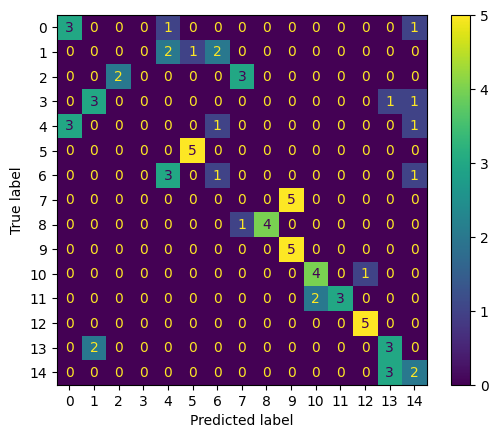

In [10]:
#Verification is perfomed here using a confusion matrix. 

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
display(pd.DataFrame(classification_report(true, predicted,output_dict=True)).transpose())
cm = confusion_matrix(true, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


In [13]:
#SVM learning with IMU data begins here - the same exact steps are taken. 

groups = imu_df['Participant'].values 
X = imu_df.drop(columns=['Class', 'Participant']).values 
le = LabelEncoder()
le.fit(imu_df['Class'].values) 
y = le.transform(imu_df['Class'].values) 
logo = LeaveOneGroupOut()
logo.get_n_splits(X, y, groups)

3

In [15]:
#print(X[0])
#print(X[0].reshape(1,-1))
#blah = clf.predict(X[8].reshape(1,-1))
#print(blah[0])
#f = []
#for i in range(0,32):
#    f.append(i)
#f = [f]
#blah = clf.predict(f)
#print(blah[0])

In [16]:
predicted = np.array([])
true = np.array([])
clf = make_pipeline(StandardScaler(), 
PCA(n_components=0.9, svd_solver='full'), 
SVC(kernel='linear', gamma='auto', class_weight='balanced')) 
for train_index, test_index in logo.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y[train_index], y[test_index] 

In [17]:
clf.fit(X_train, y_train) 
predicted = np.hstack((predicted, clf.predict(X_test)))
true = np.hstack((true, y_test))

c:\users\saruman\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\saruman\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\saruman\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

,precision,recall,f1-score,support
0.0,0.625000,1.000000,0.769231,5.000000
1.0,1.000000,1.000000,1.000000,5.000000
2.0,0.250000,0.200000,0.222222,5.000000
3.0,1.000000,1.000000,1.000000,5.000000
4.0,1.000000,0.600000,0.750000,5.000000
5.0,1.000000,1.000000,1.000000,5.000000
6.0,0.500000,1.000000,0.666667,5.000000
7.0,0.000000,0.000000,0.000000,5.000000
8.0,1.000000,0.200000,0.333333,5.000000
9.0,0.181818,0.800000,0.296296,5.000000


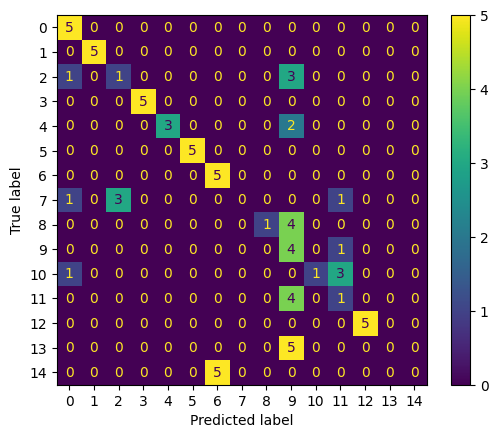

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
'''View Results'''
display(pd.DataFrame(classification_report(true, predicted,output_dict=True)).transpose())
cm = confusion_matrix(true, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [19]:
#Now, try SVM with both data types concurrently. 
combo_df = pd.concat([emg_df, imu_df], ignore_index=False,axis=1)

combo_df.drop('Class', axis=1, inplace=True)
combo_df.drop('Participant', axis=1, inplace=True)
display(combo_df)

,EMG_1_Max,EMG_1_Avg,EMG_1_Std,EMG_1_MaxPower,EMG_2_Max,EMG_2_Avg,EMG_2_Std,EMG_2_MaxPower,EMG_3_Max,EMG_3_Avg,...,Pos_Std_X,Acc_X,dOrnt_Y,dGyroY,Pos_Std_Y,Acc_Y,dOrnt_Z,dGyroZ,Pos_Std_Z,Acc_Z
0,39.495444,11.058743,9.465747,7.960758,45.529870,9.855972,8.472785,10.832573,72.558941,8.765273,...,0.017402,0.641602,0.043823,64.1875,0.008782,-0.821289,0.096680,87.2500,0.031466,0.221680
1,46.464048,10.026219,8.947698,6.900959,31.888610,8.312422,7.496613,6.777726,18.482263,4.785880,...,0.016862,0.600098,0.030212,64.5625,0.006853,-0.869141,0.076843,58.3125,0.027618,0.155273
2,52.379242,9.567361,9.260534,9.695207,36.664634,9.587891,7.837259,6.963823,23.449350,4.835777,...,0.034972,0.474121,0.023254,70.4375,0.006094,-0.898926,0.091003,41.3750,0.034520,0.098633
3,57.344526,15.223659,12.933961,36.296080,19.024203,5.019255,4.266345,1.438384,13.733171,4.236311,...,0.014353,0.547363,0.021606,55.5625,0.005033,-0.956543,0.085449,54.3750,0.030476,0.087402
4,41.126204,12.709357,11.022737,16.070694,29.530143,7.767803,6.790975,2.928319,24.093564,5.903412,...,0.012062,0.461426,0.035583,51.3750,0.007044,-0.938477,0.081543,75.5000,0.027013,0.083496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,25.139891,6.520832,5.662824,4.709528,39.298564,8.822603,7.692540,8.786456,32.382929,5.166325,...,0.031635,0.512207,0.371460,44.8125,0.150308,-0.608398,0.518921,277.8125,0.194310,0.132324
221,22.999083,6.098460,4.964906,1.856919,23.327740,7.268678,5.788846,4.992704,53.852674,8.500120,...,0.095410,0.486328,0.519653,35.6250,0.230484,-0.317383,0.544800,208.7500,0.239742,0.476562
222,19.865329,5.680397,5.117527,2.588881,69.792900,12.647261,14.618936,44.006431,76.290451,7.531928,...,0.037503,0.433105,0.732605,40.5000,0.296742,0.187988,0.572754,483.0000,0.235932,0.454102
223,45.015882,7.155416,7.533661,5.439768,101.507830,14.360429,15.183409,15.164833,42.459465,8.718361,...,0.037052,0.324707,0.679260,48.3125,0.302417,0.104492,0.536072,313.2500,0.235545,0.419434


In [20]:
#SVM learning begins here for the combine data. 

groups = emg_df['Participant'].values # Specify groups - the same groups in the same order as the EMG df are present, so 
                                       #that df is used here. The concat with the two dataframes produces two columns with 
                                       #the class and participant labels. 

#X = combo_df.drop(columns=['Class', 'Participant']).values # specify Feature columns
X = combo_df.values
le = LabelEncoder() #CReate labels
le.fit(emg_df['Class'].values) # Specify Classes - the EMG df is used here for the same reason. 
y = le.transform(emg_df['Class'].values) 
logo = LeaveOneGroupOut() 
logo.get_n_splits(X, y, groups)

3

In [21]:
predicted = np.array([])
true = np.array([])
clf = make_pipeline(StandardScaler(), 
PCA(n_components=0.9, svd_solver='full'), 
SVC(kernel='linear', gamma='auto', class_weight='balanced')) 
for train_index, test_index in logo.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y[train_index], y[test_index] 

In [22]:
clf.fit(X_train, y_train) 
predicted = np.hstack((predicted, clf.predict(X_test)))
true = np.hstack((true, y_test))

c:\users\saruman\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\saruman\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\saruman\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

,precision,recall,f1-score,support
0.0,0.555556,1.000000,0.714286,5.000000
1.0,1.000000,1.000000,1.000000,5.000000
2.0,1.000000,0.600000,0.750000,5.000000
3.0,1.000000,0.600000,0.750000,5.000000
4.0,1.000000,0.200000,0.333333,5.000000
5.0,1.000000,1.000000,1.000000,5.000000
6.0,0.454545,1.000000,0.625000,5.000000
7.0,0.250000,0.200000,0.222222,5.000000
8.0,1.000000,0.800000,0.888889,5.000000
9.0,0.500000,1.000000,0.666667,5.000000


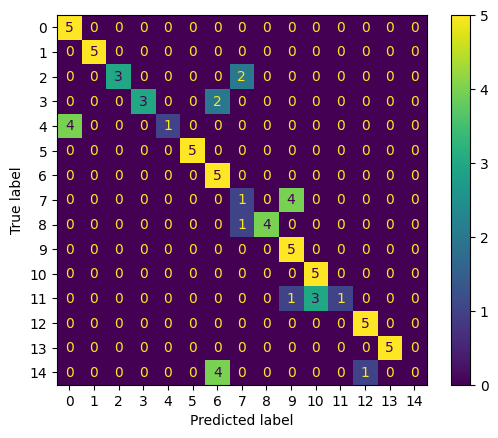

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
'''View Results'''
display(pd.DataFrame(classification_report(true, predicted,output_dict=True)).transpose())
cm = confusion_matrix(true, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()